In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad

%matplotlib inline

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [8]:
train_image_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/Dataset/1.training/1.training/436219-9328-48057-[1, 1, 0].png'
bordered_image_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_constant/436219-9328-48057-[1, 1, 0].png'
reflected_image_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_reflect/436219-9328-48057-[1, 1, 0].png'
cutmix_image_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/Dataset/cutmix_augmentation/0001-[1, 1, 1].png'
valid_img_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/2.validation/2.validation/img/00.png'
valid_mak_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/2.validation/2.validation/mask/00.png'

In [133]:
train_image = cv2.resize(cv2.imread(train_image_path), (224, 224))
bordered_image = cv2.resize(cv2.imread(bordered_image_path), (224, 224))
reflected_image = cv2.resize(cv2.imread(reflected_image_path), (224, 224))
cutmix_image = cv2.resize(cv2.imread(cutmix_image_path), (224, 224))
valid_img = cv2.resize(cv2.imread(valid_img_path), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_mak_path), (224, 224))

Text(0.5, 1.0, 'Valid Mask: [1, 1, 0]')

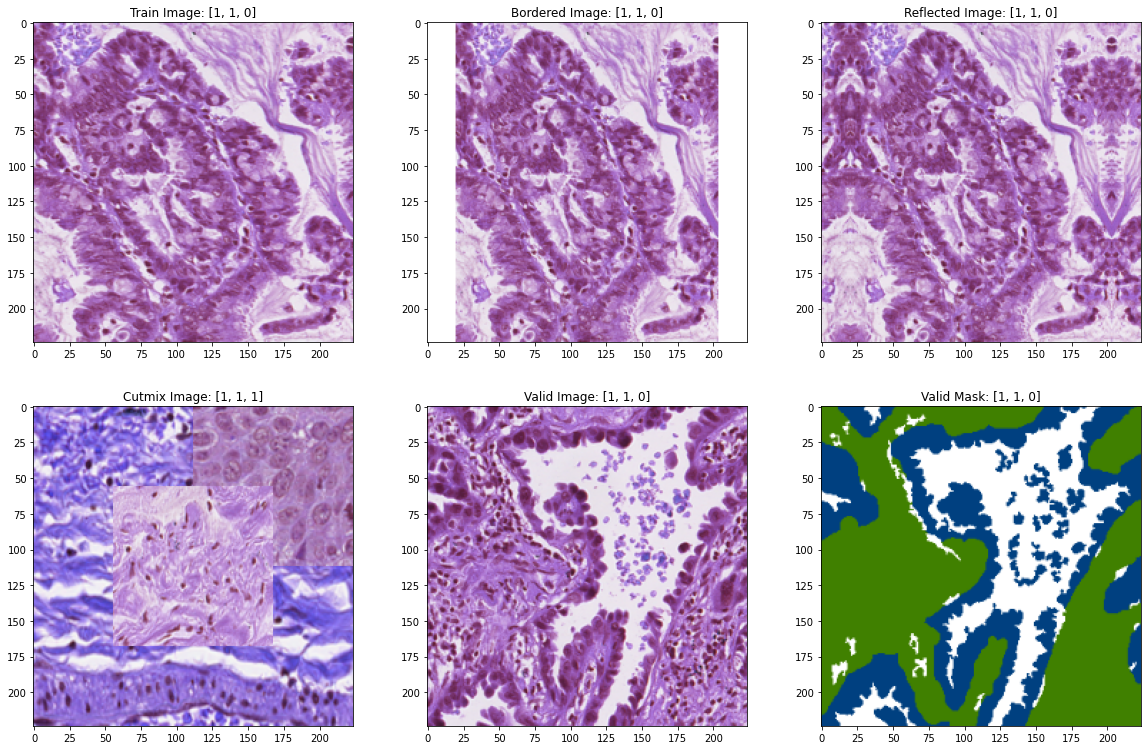

In [134]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
ax.imshow(train_image)
ax.set_title('Train Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 2)
ax.imshow(bordered_image)
ax.set_title('Bordered Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 3)
ax.imshow(reflected_image)
ax.set_title('Reflected Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 4)
ax.imshow(cutmix_image)
ax.set_title('Cutmix Image: [1, 1, 1]')

ax = fig.add_subplot(3, 3, 5)
plt.imshow(valid_img)
ax.set_title('Valid Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))
ax.set_title('Valid Mask: [1, 1, 0]')

Text(0.5, 1.0, 'Valid Mask: [1, 1, 0]')

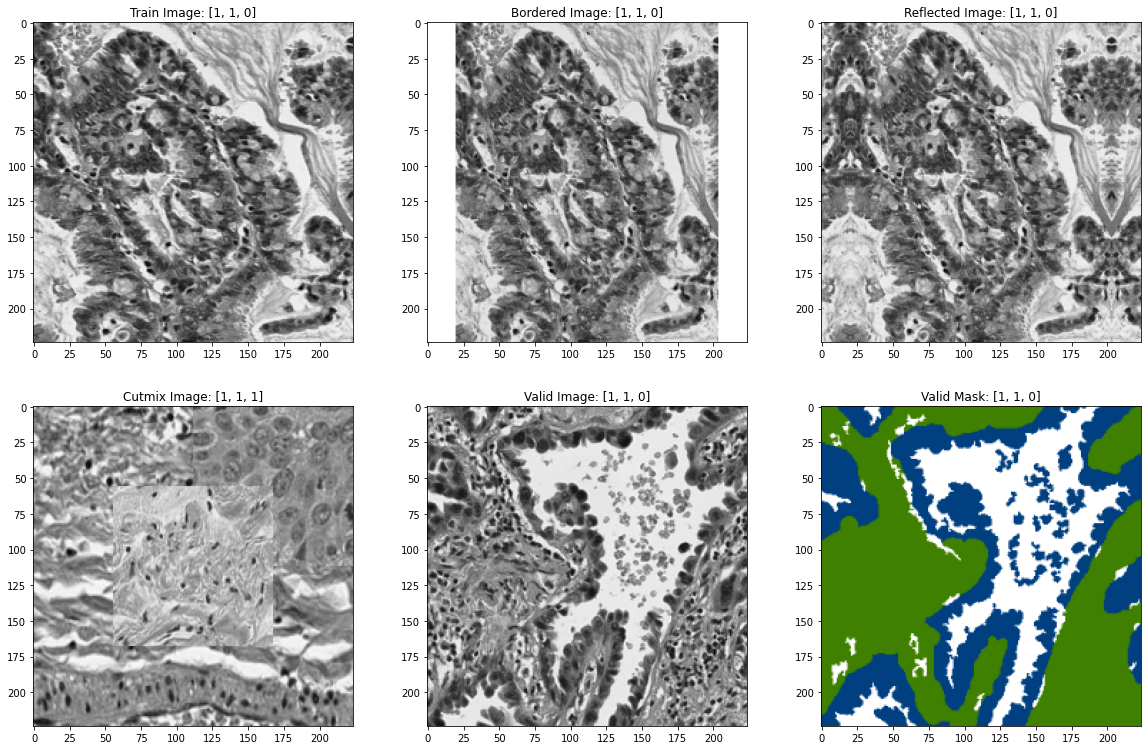

In [135]:

fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
ax.imshow(cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY), cmap='gray')
ax.set_title('Train Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 2)
ax.imshow(cv2.cvtColor(bordered_image, cv2.COLOR_BGR2GRAY), cmap='gray')
ax.set_title('Bordered Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 3)
ax.imshow(cv2.cvtColor(reflected_image, cv2.COLOR_BGR2GRAY), cmap='gray')
ax.set_title('Reflected Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 4)
ax.imshow(cv2.cvtColor(cutmix_image, cv2.COLOR_BGR2GRAY), cmap='gray')
ax.set_title('Cutmix Image: [1, 1, 1]')

ax = fig.add_subplot(3, 3, 5)
plt.imshow(cv2.cvtColor(valid_img, cv2.COLOR_BGR2GRAY), cmap='gray')
ax.set_title('Valid Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB), cmap='gray')
ax.set_title('Valid Mask: [1, 1, 0]')

In [136]:
# train image exponential transform
im = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY).astype(np.float32)
a = 0.07
c = 255 / (np.log(1 + np.abs(im.max())))
train_image_exp = c * (np.power(1 + a, im) - 1)

# bordered image exponential transform
im = cv2.cvtColor(bordered_image, cv2.COLOR_BGR2GRAY).astype(np.float32)
a = 0.07
c = 255 / (np.log(1 + np.abs(im.max())))
bordered_image_exp = c * (np.power(1 + a, im) - 1)

# reflected image exponential transform
im = cv2.cvtColor(reflected_image, cv2.COLOR_BGR2GRAY).astype(np.float32)
a = 0.07
c = 255 / (np.log(1 + np.abs(im.max())))
reflected_image_exp = c * (np.power(1 + a, im) - 1)

# cutmix image exponential transform
im = cv2.cvtColor(cutmix_image, cv2.COLOR_BGR2GRAY).astype(np.float32)
a = 0.07
c = 255 / (np.log(1 + np.abs(im.max())))
cutmix_image_exp = c * (np.power(1 + a, im) - 1)

# valid image exponential transform
im = cv2.cvtColor(valid_img, cv2.COLOR_BGR2GRAY).astype(np.float32)
a = 0.07
c = 255 / (np.log(1 + np.abs(im.max())))
valid_img_exp = c * (np.power(1 + a, im) - 1)

Text(0.5, 1.0, 'Valid Mask: [1, 1, 0]')

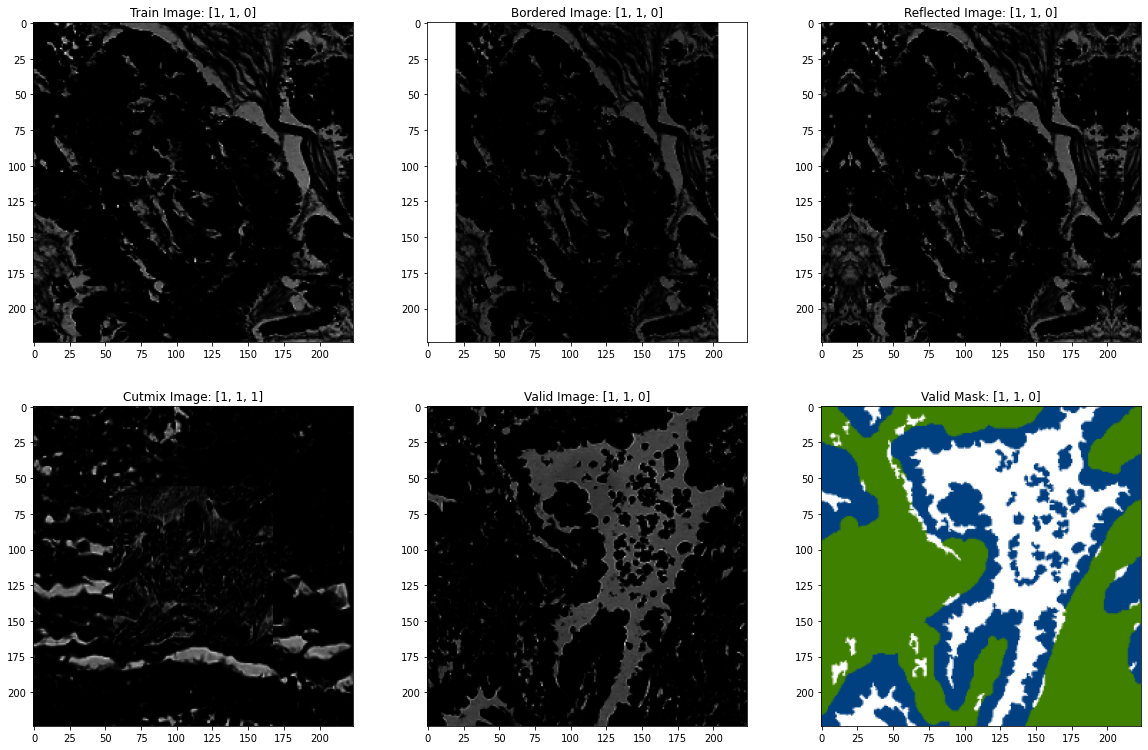

In [137]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
ax.imshow(train_image_exp, cmap='gray')
ax.set_title('Train Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 2)
ax.imshow(bordered_image_exp, cmap='gray')
ax.set_title('Bordered Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 3)
ax.imshow(reflected_image_exp, cmap='gray')
ax.set_title('Reflected Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 4)
ax.imshow(cutmix_image_exp, cmap='gray')
ax.set_title('Cutmix Image: [1, 1, 1]')

ax = fig.add_subplot(3, 3, 5)
plt.imshow(valid_img_exp, cmap='gray')
ax.set_title('Valid Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))
ax.set_title('Valid Mask: [1, 1, 0]')

In [25]:
from sklearn.cluster import KMeans

(50176, 1)
[0 1 2 3 4 5 6]


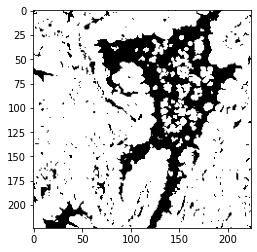

In [108]:
model = KMeans(n_clusters=7, random_state=0)

train_mask = np.float32(cv2.cvtColor(valid_img, cv2.COLOR_BGR2GRAY).reshape(-1, 1))
print(train_mask.shape)
labels = model.fit_predict(train_mask)
train_mask = labels.reshape((224, 224))
#im_labels = img_as_ubyte(im_labels)

print(np.unique(train_mask))

train_mask[train_mask > 0] = 1

plt.imshow(train_mask, cmap='gray')

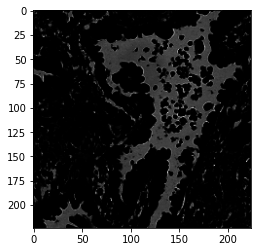

In [65]:
plt.imshow(valid_img_exp/valid_img_exp.max(), cmap='gray')

In [72]:
(valid_img_exp/valid_img_exp.max()).max()

1.0

155.36920473497364
157.94748585715624
159.18873448525636
160.4095579438486
160.95097916536537
160.95097916536537


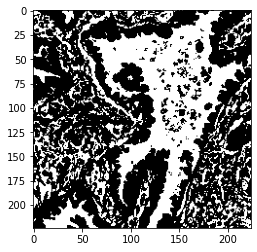

In [113]:
v = np.concatenate(cv2.cvtColor(valid_img, cv2.COLOR_BGR2GRAY))
t = v.mean()
d = np.inf
ds = 0.05
while d > ds:
  g1 = v[v>t]
  g2 = v[v<=t]
  m1 = g1.mean()
  m2 = g2.mean()
  tp = (m1 + m2)/2
  d = np.abs(t - tp)
  t = tp
  print(t)

imt = im > t

plt.imshow(imt, cmap='gray')

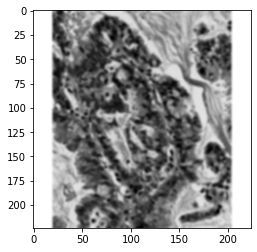

In [138]:
blurred = cv2.GaussianBlur(cv2.cvtColor(bordered_image, cv2.COLOR_BGR2GRAY), (5, 5), 0)
plt.imshow(blurred, cmap='gray')

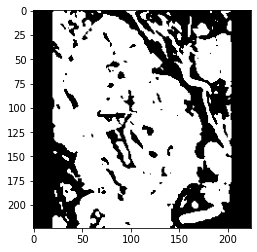

In [139]:
(T, threshInv) = cv2.threshold(blurred, 185, 255, cv2.THRESH_BINARY_INV)
plt.imshow(threshInv, cmap='gray')

In [131]:
np.quantile(blurred, q=0.75)

185.0